In [32]:
import uuid
import glob
import base64
import pymongo
import requests
import cv2 as cv
import numpy as np
import pandas as pd
import firebase_admin
import seaborn as sns
import tensorflow as tf
from PIL import ImageFile, Image
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from firebase_admin import credentials, initialize_app, storage
from sklearn.metrics import classification_report, confusion_matrix
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [33]:
print("Tensorflow version: ", tf.__version__)
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)

Tensorflow version:  2.10.1
Pandas version:  2.2.2
Numpy version:  1.24.0


In [34]:
gpus= tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  1


In [35]:
# check there is currpted image
def is_corrupted_image(image_path):
    try:
        img = Image.open(image_path) # open the image file
        img.verify() # verify that it is, in fact an image
        return False
    
    except (IOError, SyntaxError) as e:
        print('Bad file:', image_path) # print out the names of corrupt files

for image_path in glob.glob("data/PTSD/*/*.*"):
    is_corrupted_image(image_path)

In [36]:
def preprocessing_function(image):
    return tf.keras.applications.xception.preprocess_input(image)
    
def load_image_data_generator(train_path: str = 'data/PTSD'):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    zoom_range=0.2,
                                                                    shear_range=0.2,
                                                                    rotation_range=20,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    horizontal_flip=True,
                                                                    validation_split=0.2,
                                                                    preprocessing_function=preprocessing_function,
                                                                    )
    train_generator = train_datagen.flow_from_directory(
                                                        train_path,
                                                        batch_size=64,
                                                        color_mode='rgb',
                                                        target_size=(72, 72),
                                                        class_mode='categorical',
                                                        subset='training'
                                                        )   

    test_generator = train_datagen.flow_from_directory(
                                                    train_path,
                                                    batch_size=64,
                                                    color_mode='rgb',
                                                    target_size=(72, 72),
                                                    class_mode='categorical',
                                                    subset='validation'                         
                                                    )   
    return train_generator, test_generator

In [37]:
train_generator, test_generator = load_image_data_generator()

Found 23039 images belonging to 3 classes.
Found 5759 images belonging to 3 classes.


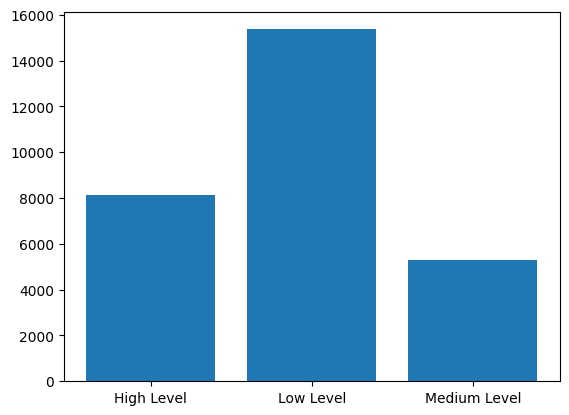

In [38]:
labels = train_generator.classes.tolist() + test_generator.classes.tolist()
value_counts = np.unique(labels, return_counts=True)

fig, ax = plt.subplots()
ax.bar(value_counts[0], value_counts[1])
ax.set_xticks(value_counts[0])
ax.set_xticklabels(list(train_generator.class_indices.keys()))
plt.show()

In [39]:
def build_model(input_shape=(72, 72, 3)):
        xception_model = tf.keras.applications.Xception(
                                                        include_top=False,
                                                        weights='imagenet',
                                                        input_shape=input_shape
                                                        )
        xception_model.trainable = True

        input_layer = tf.keras.layers.Input(shape=input_shape)
        x = xception_model(input_layer)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        output_layer = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

        model = tf.keras.Model(
                                inputs=input_layer, 
                                outputs=output_layer
                                )

        model.compile(
                        optimizer='adam', 
                        loss='categorical_crossentropy', 
                        metrics=[
                                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc')
                                ]
                        )

        return model

In [9]:
model = build_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                patience=30,
                                                monitor='val_loss',
                                                restore_best_weights=True
                                                )
history = model.fit(
                    train_generator, epochs=100,
                    validation_data = test_generator,
                    callbacks = [early_stopping]
                    )

Epoch 1/100
360/360 [==============================] - 49s 115ms/step - loss: 0.9090 - accuracy: 0.5699 - precision: 0.7187 - recall: 0.3465 - auc: 0.7596 - val_loss: 1.1588 - val_accuracy: 0.5841 - val_precision: 0.6372 - val_recall: 0.4952 - val_auc: 0.7760
Epoch 2/100
360/360 [==============================] - 40s 110ms/step - loss: 0.8149 - accuracy: 0.6272 - precision: 0.7398 - recall: 0.4543 - auc: 0.8129 - val_loss: 1.0020 - val_accuracy: 0.6293 - val_precision: 0.6843 - val_recall: 0.5399 - val_auc: 0.8113
Epoch 3/100
360/360 [==============================] - 41s 114ms/step - loss: 0.7742 - accuracy: 0.6505 - precision: 0.7512 - recall: 0.5089 - auc: 0.8341 - val_loss: 0.8866 - val_accuracy: 0.6086 - val_precision: 0.6700 - val_recall: 0.5098 - val_auc: 0.7973
Epoch 4/100
360/360 [==============================] - 41s 112ms/step - loss: 0.7402 - accuracy: 0.6671 - precision: 0.7578 - recall: 0.5423 - auc: 0.8484 - val_loss: 0.7961 - val_accuracy: 0.6604 - val_precision: 0.7051

In [11]:
model.save('artifacts/ptsd_model.h5')

In [12]:
history_cp = history.history.copy()
history_cp['loss'] = np.cumsum(history_cp['loss']) / np.arange(1, len(history_cp['loss']) + 1)
history_cp['val_loss'] = np.cumsum(history_cp['val_loss']) / np.arange(1, len(history_cp['val_loss']) + 1)

history_cp['accuracy'] = np.cumsum(history_cp['accuracy']) / np.arange(1, len(history_cp['accuracy']) + 1)
history_cp['val_accuracy'] = np.cumsum(history_cp['val_accuracy']) / np.arange(1, len(history_cp['val_accuracy']) + 1)

history_cp['precision'] = np.cumsum(history_cp['precision']) / np.arange(1, len(history_cp['precision']) + 1)
history_cp['val_precision'] = np.cumsum(history_cp['val_precision']) / np.arange(1, len(history_cp['val_precision']) + 1)

history_cp['recall'] = np.cumsum(history_cp['recall']) / np.arange(1, len(history_cp['recall']) + 1)
history_cp['val_recall'] = np.cumsum(history_cp['val_recall']) / np.arange(1, len(history_cp['val_recall']) + 1)

history_cp['auc'] = np.cumsum(history_cp['auc']) / np.arange(1, len(history_cp['auc']) + 1)
history_cp['val_auc'] = np.cumsum(history_cp['val_auc']) / np.arange(1, len(history_cp['val_auc']) + 1)

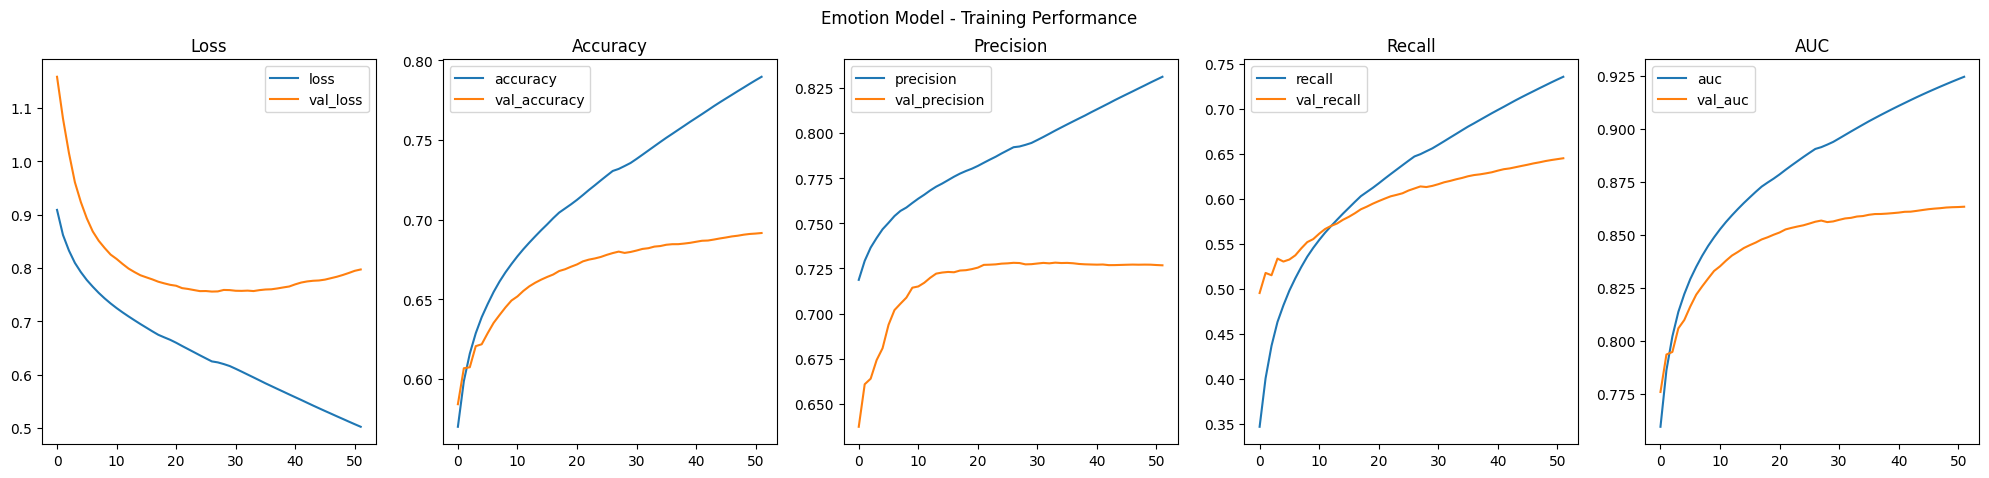

In [13]:
# Plot history_cp
plt.figure(figsize=(25, 5))
plt.subplot(1, 5, 1)
plt.plot(history_cp['loss'], label='loss')
plt.plot(history_cp['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 5, 2)
plt.plot(history_cp['accuracy'], label='accuracy')
plt.plot(history_cp['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 5, 3)
plt.plot(history_cp['precision'], label='precision')
plt.plot(history_cp['val_precision'], label='val_precision')
plt.legend()
plt.title('Precision')

plt.subplot(1, 5, 4)
plt.plot(history_cp['recall'], label='recall')
plt.plot(history_cp['val_recall'], label='val_recall')
plt.legend()
plt.title('Recall')

plt.subplot(1, 5, 5)
plt.plot(history_cp['auc'], label='auc')
plt.plot(history_cp['val_auc'], label='val_auc')
plt.legend()
plt.title('AUC')

plt.suptitle('Emotion Model - Training Performance')
plt.show()

### Evaluation

In [40]:
model_ptsd = tf.keras.models.load_model('artifacts/ptsd_model.h5')
model_ptsd.compile(
                optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')
                        ]
                )

In [43]:
def preprocessing_function(image):
    return tf.keras.applications.xception.preprocess_input(image)
    
def inference_ptsd(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (72, 72))
    image = np.expand_dims(image, axis=0)
    image = preprocessing_function(image)
    pred = model.predict(
                        image,
                        verbose=0
                        ).squeeze()
    label = pred.argmax()
    return label

In [44]:
eval_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function)
eval_generator = eval_datagen.flow_from_directory(
                                                'data/PTSD',
                                                batch_size=256,
                                                color_mode='rgb',
                                                target_size=(72, 72),
                                                class_mode='categorical'
                                                )   

Found 28798 images belonging to 3 classes.


In [45]:
img_paths = eval_generator.filepaths
Ptest = [inference_ptsd(img_path) for img_path in img_paths]

In [46]:
class_dict = eval_generator.class_indices
class_dict_rev = {v: k for k, v in class_dict.items()}

In [49]:
img_paths = eval_generator.filepaths
img_paths = [img_path.replace('\\', '/') for img_path in img_paths]
Ytest = [class_dict[img_path.split('/')[-2]] for img_path in img_paths]

In [50]:
clf_report = classification_report(
                                    Ytest,
                                    Ptest,
                                    target_names=list(class_dict.keys())    
                                    )   
cm = confusion_matrix(Ytest, Ptest)

In [51]:
print("############### Classification Report ###############")
print(clf_report)

############### Classification Report ###############
              precision    recall  f1-score   support

  High Level       0.72      0.76      0.74      8122
   Low Level       0.87      0.90      0.88     15370
Medium Level       0.72      0.60      0.66      5306

    accuracy                           0.80     28798
   macro avg       0.77      0.75      0.76     28798
weighted avg       0.80      0.80      0.80     28798



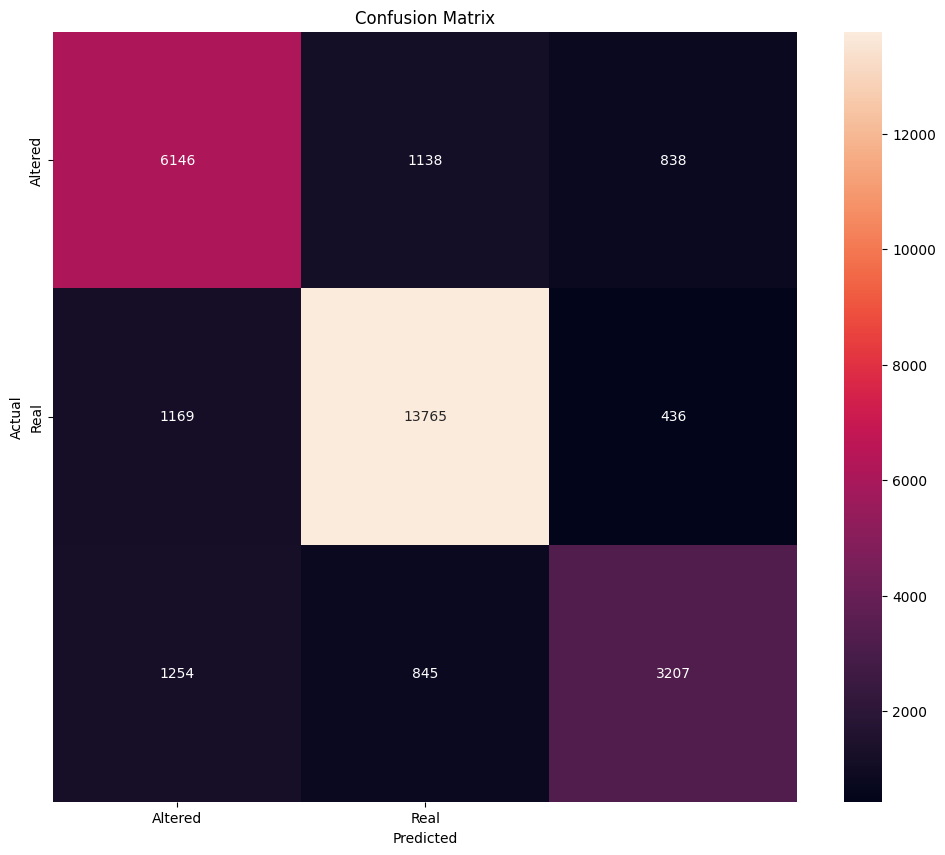

In [52]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Altered', 'Real'], yticklabels=['Altered', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()